# Location Data
I have downloaded all my location history from Google Takeout, which contains my location data from 2014-2023. 
I used the Records.json file that was downloaded in this. There are also separate folders for each year in a folder called "Semantic Location History", which I did not explore yet.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim

In [5]:
from geopy.distance import distance
from geopy.distance import Distance

## Load and Clean Data
Here I will do a few steps to make the data in the format that I want. I will:
- Load data into a pandas dataframe and look at the basic info about it
- Drop unnecessary columns and deal with null data
- Convert timestamp column to datetime format
- Group data records by hour to reduce the size of the data frame while still keeping enough precision for my purposes

In [6]:
filename = 'Takeout/Location History/Records.json'

Note: These next two cells take a *long* time at least for me. I'm sure there are ways to speed it up but I'm a patient person, so I just waited for the file to load :)

In [8]:
# this line took a while
df_records=pd.read_json(filename)

In [9]:
df_locations = pd.json_normalize(df_records['locations'])

In [10]:
# Convert Timestamp column to datetime format
df_locations['timestamp'] = pd.to_datetime(df_locations['timestamp'],format='mixed')

Let's get basic info about the dataframe:

In [11]:
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861956 entries, 0 to 1861955
Data columns (total 22 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   latitudeE7                   float64            
 1   longitudeE7                  float64            
 2   accuracy                     float64            
 3   activity                     object             
 4   source                       object             
 5   deviceTag                    int64              
 6   timestamp                    datetime64[ns, UTC]
 7   deviceDesignation            object             
 8   velocity                     float64            
 9   heading                      float64            
 10  altitude                     float64            
 11  verticalAccuracy             float64            
 12  platformType                 object             
 13  osLevel                      float64            
 14  serverTimestamp   

Whoa more than 1.8 million entries!

### Remove unneeded columns
There are a lot of columns and I don't want them all so I will drop some.

In [12]:
# Get a list of all the columns to easily copy and paste the ones I want to drop
df_locations.columns

Index(['latitudeE7', 'longitudeE7', 'accuracy', 'activity', 'source',
       'deviceTag', 'timestamp', 'deviceDesignation', 'velocity', 'heading',
       'altitude', 'verticalAccuracy', 'platformType', 'osLevel',
       'serverTimestamp', 'deviceTimestamp', 'batteryCharging', 'formFactor',
       'locationMetadata', 'inferredLocation', 'placeId',
       'activeWifiScan.accessPoints'],
      dtype='object')

In [13]:
# Drop the columns I don't care about
df_locations.drop(columns=['deviceDesignation', 'velocity', 'heading',
       'altitude', 'verticalAccuracy', 'platformType', 'osLevel',
       'serverTimestamp', 'deviceTimestamp', 'batteryCharging', 'formFactor',
       'locationMetadata', 'inferredLocation', 'placeId',
       'activeWifiScan.accessPoints','activity','source'],inplace=True)

### Remove Null Data
First see which data points are null now:

In [14]:
df_locations[df_locations['latitudeE7'].isnull()][['latitudeE7','longitudeE7','accuracy','timestamp']]

,latitudeE7,longitudeE7,accuracy,timestamp
1706603,NaN,NaN,NaN,2022-12-18 22:25:04.666000+00:00
1706604,NaN,NaN,NaN,2022-12-18 22:35:34.158000+00:00
1706605,NaN,NaN,NaN,2022-12-18 22:45:42.531000+00:00
1706606,NaN,NaN,NaN,2022-12-18 22:57:31.851000+00:00
1706618,NaN,NaN,NaN,2022-12-18 23:27:06.622000+00:00
1706619,NaN,NaN,NaN,2022-12-18 23:35:52.752000+00:00
1706620,NaN,NaN,NaN,2022-12-18 23:50:06.056000+00:00


They happen to be all in one day within a short time span. If I remove those, am I missing much data? I can see how many other data points are that same day:

In [15]:
len(df_locations[df_locations['timestamp'].dt.date == pd.to_datetime('2022-12-18').date()])

450

Then I think it's safe to say I can just drop those rows and not worry about it.

In [16]:
df_locations.dropna(inplace=True)

### Group data by hour
As can be seen from the brief sample of timestamps shown earlier, there are often multiple data points per hour. For my purposes, hourly precision is more than enough, so I'm going to group by the date and hour, and aggregate the location to be the mean latitude and longitude of that hour. 

In [17]:
df_locations['date'] = df_locations['timestamp'].dt.date

In [18]:
df_locations['hour'] = df_locations['timestamp'].dt.hour

In [19]:
df_locations = df_locations.groupby([df_locations['date'],df_locations['hour']]).aggregate(
    latitudeE7 = ('latitudeE7','mean'),longitudeE7 = ('longitudeE7','mean')).reset_index()

In [20]:
df_locations.shape

(80835, 4)

Okay! 80 thousand entries is still plenty for me to work with :)

### Create latitude and longitude columns
Looks like the current data has latitude and longitude times 10^7. I'm going to divide that out to get regular latitude and longitude, just to make it slightly easier for me to look at (and copy and paste values into google maps to sanity check things).

In [21]:
df_locations['latitude'] = (df_locations['latitudeE7']/1E7).round(decimals=1)
df_locations['longitude'] = (df_locations['longitudeE7']/1E7).round(decimals=1)

## Get list of places 
I don't actually have latitudes and longitudes all memorized! So I will use geopy to search for the city/state names. However, doing that 80 thousand times would be pretty redundant since a lot of these places are the same. Also, I don't actually need the locations to be too precise so I'm going to round to one decimal place to do the search. This means it will be around the right city, but it's not going to ever show my exact address.

In [22]:
df_places = df_locations[['latitude','longitude']].round(decimals=1)

In [23]:
df_places = df_places.groupby(['latitude','longitude']).aggregate(count=('latitude','count')).reset_index()

In [24]:
df_places.shape

(1057, 3)

Okay we've reduced this down to about a thousand places to look up using geopy. This still takes a while for me, but it's more doable.

In [25]:
df_places['city'] = None
df_places['county'] = None
df_places['state'] = None
df_places['country'] = None

In [26]:
geolocator = Nominatim(user_agent="read_place_data")
#df_locations['location'] = geolocator.reverse(zip(df_locations['latitude'],df_locations['longitude']))
coords = list(zip(df_places['latitude'],df_places['longitude']))
full_address=[]
for i in range(0,len(coords)):
    if df_places.loc[i,'city']==None:
        location = geolocator.reverse(coords[i])
        # had to include this if statement because I had one weird data point making an error
        if location is not None:
            address=location.raw['address']
            # traverse the data
            df_places.loc[i,'city'] = address.get('city', '')
            df_places.loc[i,'county'] = address.get('county', '')
            df_places.loc[i,'state'] = address.get('state', '')
            df_places.loc[i,'country'] = address.get('country', '')

In [27]:
df_places.isnull().sum()

latitude     0
longitude    0
count        0
city         1
county       1
state        1
country      1
dtype: int64

Okay looks like there's one data point that is null, let's see what it is:

In [28]:
df_places[df_places['county'].isnull()]

,latitude,longitude,count,city,county,state,country
1056,66.7,-28.3,1,None,None,None,None


I put that into google maps and it's in between Greenland and Iceland. Either an anomalous data point or in the middle of a flight sometime. I'll just leave it as is for now but note that I might throw it out later.

Now I want this list of places to be merged with my full data frame:

In [29]:
df_locations_merged = df_locations.merge(how='left',right=df_places,left_on=['latitude','longitude'],right_on=['latitude','longitude'])

I'll drop the latitude and longitude E7 from this merged data frame. I can come back to them in the df_locations data frame if I need the full data for some reason. 

In [30]:
df_locations_merged.drop(columns=['latitudeE7','longitudeE7'],inplace=True)

## Basic Checking

I want to do a few checks to see if my data makes some sense. I'll start with just a sample of a few data points to see if the merge did what I think it should have done.

In [31]:
df_locations_merged.sample(5)

,date,hour,latitude,longitude,count,city,county,state,country
22688,2016-11-01,2,30.3,-91.0,44,,Ascension Parish,Louisiana,United States
20470,2016-07-30,5,30.4,-91.2,14139,Baton Rouge,East Baton Rouge Parish,Louisiana,United States
50030,2020-01-17,9,37.1,-76.5,18678,,Newport News,Virginia,United States
10824,2015-06-15,16,30.5,-90.8,219,,Livingston Parish,Louisiana,United States
77674,2023-05-30,21,33.1,-97.1,5328,,Denton County,Texas,United States


Yes! These are really places that I've been and the dates seem to make sense. I know that I visited collaborators in Hannover in August 2015, I stopped in London on the way to a meeting in Cardiff in September 2022, I was living in Fullerton in 2019, and visited my family in Denton county all the time until I moved to Denton in 2023.

In [32]:
# Realized I needed to fix the datetime values again because something didn't work and I got an error
df_locations_merged['date'] = pd.to_datetime(df_locations_merged['date'], errors='coerce')

In [33]:
#df_locations_merged[df_locations_merged['date'].dt.year<2015]

What countries are listed?

In [34]:
df_locations_merged['country'].unique()

array(['United States', '中国', 'Deutschland', 'United Kingdom',
       'Magyarország', 'Nederland', 'Schweiz/Suisse/Svizzera/Svizra',
       'France', 'Sverige', 'Suomi / Finland', 'Danmark', None,
       'België / Belgique / Belgien'], dtype=object)

Most of this checks out! I thought Finland was wrong at first but actually I think I did have an airport stop there (unintentionally - I had gotten stuck in Sweden overnight on my way to a meeting in Germany because of a cancelled flight, and then I think the next day rerouted through Finland.)
But Denmark? Maybe another airport stop? I need to check that one.
And the "None" value from earlier. Let me check when that was, now that I have the dates combined with it.

In [35]:
df_locations_merged[df_locations_merged.isnull().any(axis=1)]


,date,hour,latitude,longitude,count,city,county,state,country
36802,2018-06-23,17,66.7,-28.3,1,None,None,None,None


Hmmm June 2023. That was when I flew to Germany so maybe this was on the way?

In [36]:
df_locations_merged[df_locations_merged['date']==pd.to_datetime('2018-06-23')]

,date,hour,latitude,longitude,count,city,county,state,country
36787,2018-06-23,0,52.5,13.3,16,Berlin,,,Deutschland
36788,2018-06-23,1,52.5,13.3,16,Berlin,,,Deutschland
36789,2018-06-23,2,52.5,13.3,16,Berlin,,,Deutschland
36790,2018-06-23,3,52.5,13.3,16,Berlin,,,Deutschland
36791,2018-06-23,4,52.5,13.3,16,Berlin,,,Deutschland
36792,2018-06-23,5,52.5,13.4,3,Berlin,,,Deutschland
36793,2018-06-23,6,52.5,13.4,3,Berlin,,,Deutschland
36794,2018-06-23,7,52.5,13.4,3,Berlin,,,Deutschland
36795,2018-06-23,8,52.5,13.3,16,Berlin,,,Deutschland
36796,2018-06-23,9,52.6,13.3,3,Berlin,,,Deutschland


Okay that actually makes sense! That would be potentially en route from Denmark to Chicago. I'm going to remove the point for now anyway but it's good to know that it is not complete nonsense.

And there's the Denmark points! I did a quick search in my email for "Denmark" and found that I did in fact fly through Copenhagen on that day. Solving all the mysteries!

This data snippet also brings up another thing to be aware of though. I don't remember flying into Chicago at almost midnight, so I am realizing now that the time zone for this might be UTC time. I think that's fine but just something I need to remember if I want to do anything precise with the times.

In [37]:
df_locations_merged.dropna(inplace=True)

## Combine Some Entries

I care less about precise latitude and longitude (and I've already rounded them anyway) than about the location names, so I want to focus on those from now on. Also, I don't need multiple entries a day for the same place, so I'll group by date and location

In [38]:
df_simple = df_locations_merged.groupby(['date', 'city','county','state','country'])['hour'].mean().reset_index()

In [39]:
df_simple.head()

,date,city,county,state,country,hour
0,2014-03-03,Baton Rouge,East Baton Rouge Parish,Louisiana,United States,19.000000
1,2014-03-04,Baton Rouge,East Baton Rouge Parish,Louisiana,United States,12.409091
2,2014-03-05,Baton Rouge,East Baton Rouge Parish,Louisiana,United States,7.500000
3,2014-03-06,,Livingston Parish,Louisiana,United States,19.000000
4,2014-03-06,Baton Rouge,East Baton Rouge Parish,Louisiana,United States,9.375000


In [40]:
df_simple.shape

(7063, 6)

Okay! My simplified data frame is much reduced in size, just has one entry per day if I stayed in the same city all day, but does have multiple entries if my location changed. I'm not sure if the average hour of the entries is at all important. I'll leave it for now but probably not do anything with it.

## Focus on 2019-2023
I was a physics professor in Virginia from Fall 2019 to Summer 2023. It was an incredible chapter of my life in so many ways, but also very challenging, especially because of the pandemic. While work was online in the first five months of the pandemic, I stayed in Texas with my family. I made some amazing friends in Virginia, but I was also flying back to Texas as often as possible. Eventually, I realized I just needed to relocate to Texas, hence why I am here now looking for a new job! 

I'm interested in the data from that chapter of my life. I felt like I was constantly on the road, either for work or family, and as much as I loved Virginia it was difficult to grow roots there. I predict that my location data will help me see tangibly just how often I was traveling.

In [41]:
# Create a data frame just from the time I lived in Virginia
va_df = df_simple[(df_simple['date']>pd.to_datetime('2019-08-05')) & (df_simple['date']<pd.to_datetime('2023-06-18'))]

In [42]:
# And then group that data frame by date, with a list of locations for that day
va_df=va_df.groupby('date').aggregate(cities=('city',lambda x:list(set(x))),
                                      counties=('county',lambda x:list(set(x))),
                                      states=('state',lambda x:list(set(x))),
                                      countries=('country',lambda x:list(set(x)))
                                     ).reset_index()

Check the top few levels of the value counts for states:

In [43]:
va_df['states'].value_counts().head(10)

states
[Virginia]                           805
[Texas]                              464
[Texas, Virginia]                     19
[Washington]                          13
[North Carolina, Virginia]            13
[Illinois]                            11
[Louisiana]                            9
[California]                           7
[North Carolina, Texas, Virginia]      6
[Oklahoma, Texas]                      4
Name: count, dtype: int64

Wow! Even just there, I can see that I was in Texas for over half the number of days that I was in Virginia. A lot of that was that first part of the pandemic when I stayed for extra extended amounts of time, but there was also just a lot of back and forth. But a visualization would be cooler. So let's rework this data frame to just focus on how much I was in Virginia, Texas, or multiple/other states.

In [44]:
va_df.loc[(va_df['states'].str.len()>1),'states']='Multiple/Other' # or could label as "Multiple"
va_df.loc[(va_df['states'].str.len()==1),'states'] = [''.join(map(str,l)) 
                                                     for l in va_df.loc[(va_df['states'].str.len()==1),'states']]
va_df.loc[~va_df['states'].isin(['Virginia','Texas','Multiple/Other']),'states']='Multiple/Other'

In [45]:
state_counts = va_df['states'].value_counts().reset_index()

Text(0.5, 0, '')

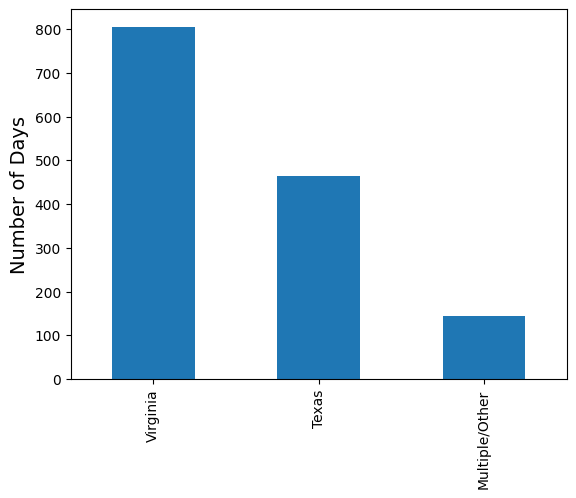

In [46]:
state_counts.plot(kind='bar',x='states',y='count',legend=False)
plt.ylabel('Number of Days', fontsize=14)
plt.xlabel('')

I like the way those three stair step bars look! And this is helpful to see that not only was there a large amount of time in Texas, there's also a significant amount of time where I was either traveling to other states or in transit between Virginia and Texas. No wonder I was exhausted all the time!

Number of days is harder to conceptualize here though so let me add a months column, estimating 30.5 days as a month.

In [47]:
state_counts['months']=state_counts['count']/30.5

Text(0.5, 0, '')

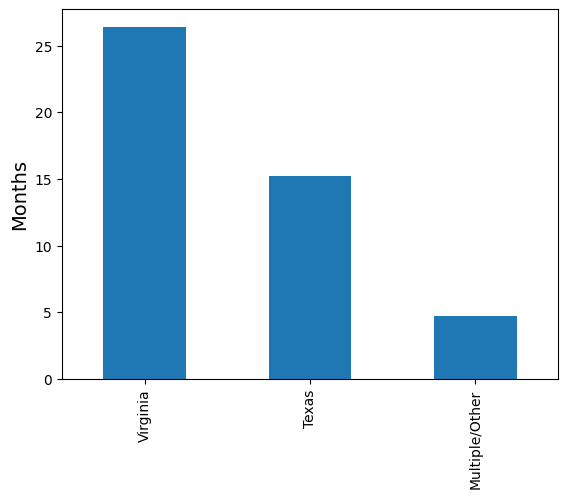

In [48]:
state_counts.plot(kind='bar',legend=False,x='states', y='months')
plt.ylabel('Months', fontsize=14)
plt.xlabel('')

Or a pie chart if you prefer!

Text(0, 0.5, '')

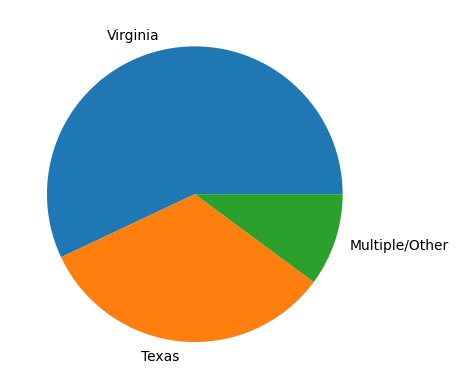

In [49]:
state_counts.plot(kind='pie',legend=False,labels=state_counts['states'], y='months')
plt.xlabel('')
plt.ylabel('')

## Estimated Distance per Day

As seen above, my life has involved a lot of traveling!
I'm curious to see if I can very roughly estimate the total distance traveled per day. I'll do this by calculating the distance between each successive point in my hourly location data frame, then summing them to find the distance traveled in each day. Note there are some estimations here, since when I aggregated the data by hour, I just took the average latitude and longitude. 

In [50]:
# I'm remaking the latitude and longitude columns without rounding for this, 
# although I don't think it actually matters that much
df_locations['latitude']=df_locations['latitudeE7']/1E7
df_locations['longitude']=df_locations['longitudeE7']/1E7

In [51]:
# Initialize distance column
df_locations['distance']=None

This next cell is another one that takes a couple minutes for me, calculating the distances between each data point. 

In [52]:
for j in range(1,len(df_locations)):   
    df_locations.loc[j,'distance'] = distance(df_locations.loc[j-1,['latitude','longitude']],
                                            df_locations.loc[j,['latitude','longitude']])

In [53]:
df_distance=df_locations.groupby('date')['distance'].sum().reset_index()
df_distance['miles']=[x.miles for x in df_distance['distance']]

First a simple scatter plot to see what the data looks like.

Text(0.5, 0, 'Date')

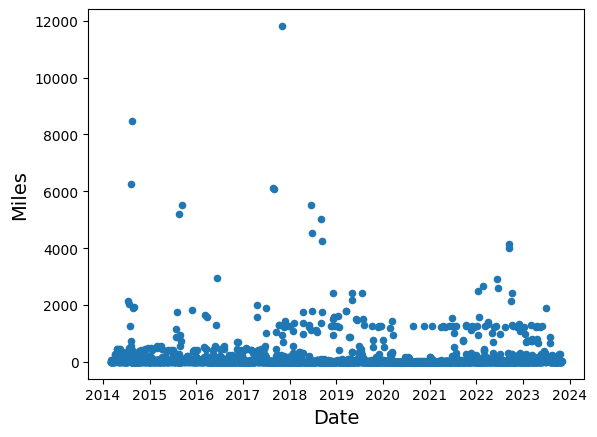

In [54]:
df_distance.plot(x='date',y='miles',kind='scatter')
plt.ylabel('Miles', fontsize=14)
plt.xlabel('Date', fontsize=14)

It's obviously a quick and messy plot, but a few things already jump out at me:
- There are several high outliers that I want to check
- Beginning around mid-2017 through mid-2023 there are a lot more points around 1500-ish miles, present quite frequently except for a few month gap in 2020 (hello early pandemic). It just so happens that in 2017 I moved from Baton Rouge (which is a few hundred miles from Dallas) to Fullerton, CA (about 1200 miles west of Dallas). And in 2019 I moved to Newport News, VA (about 1200 miles east of Dallas). Because of my frequent trips to the Dallas area to visit my family, I'm not at all surprised that this cluster of distances shows up so clearly.
- I think there are some interesting structures in the points lower down that are all clumped together, which change over the different eras of my life. But I need to make some other visualizations to really show this better.

Real quick I'll just zoom in so you can see more clearly the cluster of points around 1200 miles:

(0.0, 2000.0)

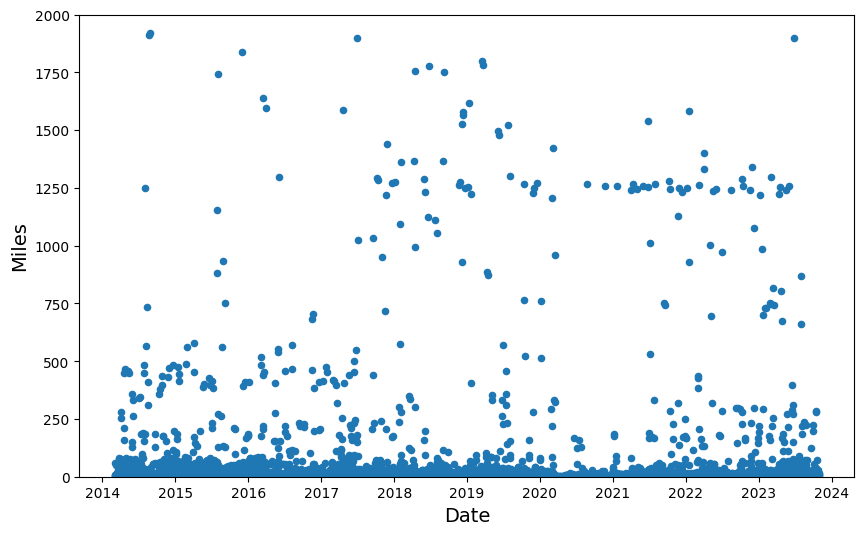

In [55]:
df_distance.plot(x='date',y='miles',kind='scatter',figsize=[10,6])
plt.ylabel('Miles', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylim(0,2000)

And now that I've done that, I can also see a clear cluster of points at almost 500 miles up until mid 2017, showing my many drives from Baton Rouge to the Dallas area.

I can also begin to see interesting changes in the dense clusters of points that represent my "normal" daily life when I'm not traveling. I can see those few months in 2020 when I barely moved outside my sister's house where we quarantined, except for short walks. I can see that even after that, up until early 2021 (perhaps around when I got the covid vaccine) there seems to be more lower distance days. This will probably be easier to see with other plots, but I think it's interesting that even this simple scatter plot can show that!

But first let me see about those outliers. I'm curious!

## Error Checking in Distance Data

First I'm goint to check Days when the distance was over 5000 miles.

In [56]:
df_distance[df_distance['miles']>5000].sort_values(by='miles',ascending=False)

,date,distance,miles
1340,2017-11-03,19021.446172274544 km,11819.378686
164,2014-08-15,13613.123377666525 km,8458.802703
155,2014-08-05,10081.237902966046 km,6264.190815
1272,2017-08-27,9818.381903093199 km,6100.859669
1278,2017-09-02,9813.113273577736 km,6097.585894
1566,2018-06-17,8886.611935600082 km,5521.884653
554,2015-09-09,8879.198038602133 km,5517.277871
532,2015-08-18,8360.80685086157 km,5195.164521
1643,2018-09-02,8089.728418336344 km,5026.724192


Most of these dates make sense to me except the first one Here's what I think these are just based on the dates (without actually checking my flight receipts to check exact days and measuring the distances myself):
- 1: I don't remember traveling anywhere in November 2017 so that seems wrong. I'll need to check that date.
- 2 & 3: Trip to and from China on a visit to one of my best friends
- 4 & 5: Conference travel to Switzerland
- 6: Conference travel to Germany
- 7 & 8: Trips to and from Europe for conference and meetings with collaborators
- 9: Conference travel to the Netherlands

So I'm only concerned about the first date in question. Let me see where I was on that day:

In [57]:
df_locations_merged[df_locations_merged['date']==pd.to_datetime('2017-11-03')]

,date,hour,latitude,longitude,count,city,county,state,country
31337,2017-11-03,0,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31338,2017-11-03,1,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31339,2017-11-03,2,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31340,2017-11-03,3,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31341,2017-11-03,4,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31342,2017-11-03,5,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31343,2017-11-03,6,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31344,2017-11-03,7,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31345,2017-11-03,8,33.9,-117.9,13216,Fullerton,Orange County,California,United States
31346,2017-11-03,9,33.9,-117.9,13216,Fullerton,Orange County,California,United States


Okay! So for most of the day I was just in California but at 4pm I was suddenly in Switzerland! 
I had traveled to Switzerland earlier that year, so it didn't raise an alarm when I saw that in the list of countries. But I definitely didn't teleport there and back to Fullerton on this day! 

And another strange thing is that I double checked in my Google Timeline accessible online, and it does *not* have that point! I'm not sure what is different about the Takeout data. Anyway, I will obviously delete that row.

This makes me concerned that there may be other points that are way off. I'm okay with this data not being perfect, but I want to at least do some basic checking to see if I can find anything else *obviously* wrong. I also want to think about other ways I might have been able to identify this point.

One simple thing I could do is estimate my speed by taking the distance divided by the time difference. This is of course not very precise because I'm only rounding to the nearest hour, but it's at least a basic check.

In [58]:
for j in range(1,len(df_locations)):
    if df_locations.loc[j,'date']==df_locations.loc[j-1,'date']:
        timediff = df_locations.loc[j,'hour'] - df_locations.loc[j-1,'hour']
        df_locations.loc[j,'est. speed'] = (df_locations.loc[j,'distance'].miles)/(timediff)
    else: 
        daydiff=(df_locations.loc[j,'date']-df_locations.loc[j-1,'date']).days
        timediff=df_locations.loc[j,'hour'] + 24*daydiff - df_locations.loc[j-1,'hour']
        df_locations.loc[j,'est. speed'] = (df_locations.loc[j,'distance'].miles)/(timediff)

In [59]:
# Check for speeds greater than 800mph
df_locations[(abs(df_locations['est. speed'])>800)]
# I could check more but I'm just goint to go with this for now

,date,hour,latitudeE7,longitudeE7,latitude,longitude,distance,est. speed
19402,2016-06-14,16,3.342126e+08,-1.077232e+09,33.421256,-107.723192,2996.8230180968876 km,931.069746
31353,2017-11-03,16,4.623120e+08,6.054595e+07,46.231196,6.054595,9506.607334798833 km,5907.131934
31354,2017-11-03,17,3.387986e+08,-1.178856e+09,33.879859,-117.885602,9507.160493571973 km,5907.475651


As expected, my teleportation to and from Switzerland shows a ridiculous estimated speed. 

There's also one more interesting point on 2016-06-14. The estimated speed isn't nearly as ridiculous when you remember that my time measurement is not precise, but still worth checking out. Let me look at those entries in my data frame including location names:

In [60]:
df_locations_merged.loc[19400:19403,:]

,date,hour,latitude,longitude,count,city,county,state,country
19400,2016-06-14,13,40.8,-73.9,61,City of New York,,New York,United States
19401,2016-06-14,14,40.4,-75.0,1,Solebury Township,Bucks County,Pennsylvania,United States
19402,2016-06-14,16,33.4,-107.7,1,,Sierra County,New Mexico,United States
19403,2016-06-14,17,32.9,-97.0,146,Irving,Dallas County,Texas,United States


So I know that in June 2016 I took a trip to New York, and this shows my return to DFW. Pennsylvania might be close enough to on the way. *However*, why would my flight go through New Mexico? 

Once again, I checked my Google Timeline, and it just shows NYC to DFW, not this New Mexico point! So, note for later, find out what the difference is between this download and what I get on the Timeline online. For now, I'll just add this to my list of points to manually delete.

In [61]:
#Hard coding in dropping bad 11-03-17 and 06-14-16 data point for now, 
# Removing from locations and merged locations data frames
# NOTE FOR LATER: remove from simple data frame as well - will be a different row number
df_locations.drop(31353,inplace=True)
df_locations.drop(19402,inplace=True)
df_locations_merged.drop(31353,inplace=True)
df_locations_merged.drop(19402,inplace=True)

Now without that point I should redo my distance data frame:

In [62]:
df_distance=df_locations.groupby('date')['distance'].sum().reset_index()
df_distance['miles']=[x.miles for x in df_distance['distance']]

## Distance over Time

Now that I have clean(er) data, I'm going to group by year to see my total miles each year.

In [63]:
df_distance['year']=[x.year for x in df_distance['date']]

In [64]:
df_distance_yearly=df_distance.groupby(['year'])['miles'].sum().reset_index()

Text(0.5, 0, 'Year')

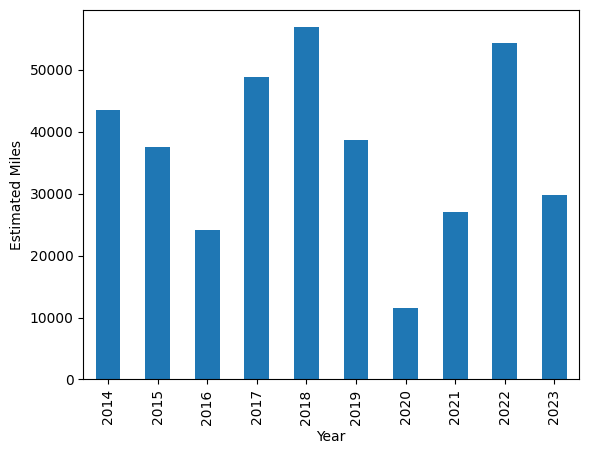

In [65]:
df_distance_yearly.plot(kind='bar',y='miles',x='year',legend=False)
plt.ylabel('Estimated Miles')
plt.xlabel('Year')

I love seeing this plot tell the story of my life these past 9 years! 2017, 2018, and 2022 all had more major work trips than usual. 2016 was when I was really trying hard to focus and finish my dissertation, so I traveled a bit less (at least major trips). 2020 was...2020. And so was 2021, although I did start traveling more that year! 

**Note about 2023:** I downloaded this data in October 2023, so it is not the full year. However, I haven't traveled nearly as much in the last few months, so it will probably not change too much once I download the full year.

*Total* mileage is one thing, but another interesting measure is how many days I was traveling more than, let's say 500 miles. This will show a little bit of a different picture, since a huge trip (like to China in 2014) can add a lot of miles for just a couple of travel days. 

In [66]:
days_over500 = df_distance[df_distance['miles']>500].reset_index()

In [67]:
days_over500

,index,date,distance,miles,year
0,133,2014-07-14,3449.005341237435 km,2143.112561,2014
1,143,2014-07-24,3305.9216437267814 km,2054.204473,2014
2,154,2014-08-04,2013.6188975833036 km,1251.204775,2014
3,155,2014-08-05,10081.237902966046 km,6264.190815,2014
4,159,2014-08-09,913.7273233000144 km,567.763836,2014
...,...,...,...,...,...
157,3361,2023-05-17,1996.7740706471259 km,1240.737885,2023
158,3375,2023-05-31,2028.3762558480594 km,1260.374572,2023
159,3404,2023-06-29,3055.1166233149224 km,1898.361459,2023
160,3438,2023-08-02,1396.485373275685 km,867.735781,2023


In [68]:
days_over500 = days_over500.groupby(['year']).aggregate(count=('date','count')).reset_index()

Text(0.5, 1.0, 'Number of Days with Over 500 Miles')

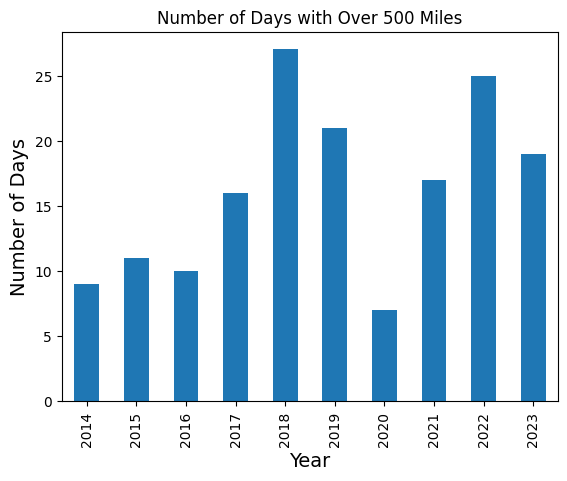

In [69]:
days_over500.plot(kind='bar',y='count',x='year',legend=False)
plt.ylabel('Number of Days', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('Number of Days with Over 500 Miles')

This is helpful for me to visualize how intense some of these years were!
Having 20 days out of the year be traveling this far can feel like a lot. 
But note: this makes it look like 2014-2016 I didn't have as many days devoted to travel. *However* there were a lot of long days driving from Baton Rouge to Texas, which wouldn't show up because it's a bit under 500 miles.
But this plot does show how much more often I was flying in the past few years. 

## Notes for future work:
- Think about whether there are other ways of checking for anomalous data points
- Find out why Google Takeout data seems to give me some things that are not in Timeline
- Explore more about the distributions of distances during different years